In [5]:
# coding: utf-8
import sys
sys.path.append('dl')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb
sys.path.append('dl/ch06')
from rnnlm import Rnnlm

In [6]:
# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 35     # RNN을 펼치는 크기
lr = 20.0
max_epoch = 4
max_grad = 0.25

In [7]:
# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

Done


In [25]:
# 모델 생성
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

In [ ]:
# 기울기 클리핑을 적용하여 학습
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

In [ ]:
# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('테스트 퍼플렉서티: ', ppl_test)

#### 기울기 크기 변화
##### 기울기 폭발로 오버플로가 생기거나 반대로 작으면 기울기가 소실됨

In [15]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt

In [16]:
N = 2   # 미니배치 크기
H = 3   # 은닉 상태 벡터의 차원 수
T = 20  # 시계열 데이터의 길이

In [18]:
dh = np.ones((N, H))

np.random.seed(3) # 재현할 수 있도록 난수의 시드 고정

Wh = np.random.randn(H, H)
#Wh = np.random.randn(H, H) * 0.5

In [19]:
norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

norm_list

[2.4684068094579303,
 3.3357049741610365,
 4.783279375373182,
 6.279587332087612,
 8.080776465019053,
 10.251163032292936,
 12.936063506609896,
 16.276861327786712,
 20.45482961834598,
 25.688972842084684,
 32.25315718048336,
 40.48895641683869,
 50.8244073070191,
 63.79612654485427,
 80.07737014308985,
 100.5129892205125,
 126.16331847536823,
 158.35920648258823,
 198.7710796761195,
 249.495615421267]

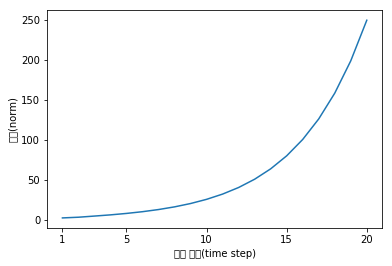

In [20]:
plt.plot(np.arange(len(norm_list)), norm_list)
plt.xticks([0, 4, 9, 14, 19], [1, 5, 10, 15, 20])
plt.xlabel('시간 크기(time step)')
plt.ylabel('노름(norm)')
plt.show()

### 기울기 클리핑
##### 기울기 변화에 대한 대처로 기울기가 조건을 넘으면 수정

In [21]:
# coding: utf-8
import numpy as np

In [22]:
dW1 = np.random.rand(3, 3) * 10
dW2 = np.random.rand(3, 3) * 10
grads = [dW1, dW2]
max_norm = 5.0

In [23]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

In [24]:
print('before:', dW1.flatten())
clip_grads(grads, max_norm)
print('after:', dW1.flatten())

before: [6.49144048 2.78487283 6.76254902 5.90862817 0.23981882 5.58854088
 2.59252447 4.15101197 2.83525082]
after: [1.49503731 0.64138134 1.55747605 1.36081038 0.05523244 1.28709139
 0.59708178 0.95601551 0.65298384]
